# Exercise 11.1
Exploring how a linear regression depends on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the gaussian noise parameter $\sigma$.\
The [HParams dashboard of Tensorboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) will be used to display the results of a grid search on such hyperparameters.


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


from global_utils import *
from tqdm import tqdm
from tensorboard.plugins.hparams import api as hp
from keras.layers import Dense
from tensorflow import keras
from IPython.display import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme("notebook")


SECTION = "11"

# This metric will be used to evaluate model performance
METRIC = "mae"

RESULTS_DIR = results_dir(SECTION) / f"{SECTION}.1"
# The path where logs will be stored
LOGDIR = RESULTS_DIR / "logs" / "hparam_tuning"


# Setting the random seeds for reproducibility
tf.random.set_seed(1)
#  Numpy has Generators now for random operations
rng = np.random.default_rng(1)


# Defining the problem's hyperparameters and their sampling space:
# - the number of epochs
hp_n_epochs = hp.HParam("n_epochs", hp.Discrete([1, 10, 100]))
# - the number of training points
hp_n_tpoints = hp.HParam("n_training", hp.Discrete([10, 100, 1000]))
# - the gaussian noise's sigma
hp_sigma = hp.HParam("sigma", hp.RealInterval(0.0, 0.5))


with tf.summary.create_file_writer(f"{LOGDIR}").as_default():
    hp.hparams_config(
        hparams=[hp_n_epochs, hp_n_tpoints, hp_sigma],
        metrics=[hp.Metric(METRIC, display_name="Mean absolute error")],
    )

# Setting the linear parameters
m = 2.0
q = 1.0

#  Declaring the model architecture
model = keras.Sequential([Dense(1, input_shape=(1,))])
# Generating a set of starting parameters
model.compile(optimizer="sgd", loss="mse", metrics=[METRIC])
# Saving them, so that every subsequent run starts from the same configuration
model.save_weights(RESULTS_DIR / "initial_weights.tf")


def evaluate_params(hparams, **kwargs):
    """Evaluates a set of hyperparameters using the provided metric and a single neuron model, optimized with scalar gradiend descent

    Args:
        hparams: The set of hyperparameters to evaluate.
        metric: The metric to use.
    Returns:
        Tuple[float, float]: Evaluation loss and metric.
    """
    x_train = rng.uniform(-1, 1, hparams[hp_n_tpoints])
    y_train = rng.normal(m * x_train + q, hparams[hp_sigma])

    # Restoring the model's initial configuration
    model.load_weights(RESULTS_DIR / "initial_weights.tf")
    model.fit(
        x_train,
        y_train,
        epochs=hparams[hp_n_epochs],
        verbose=0,
        shuffle=True,
        **kwargs
    )

    x_validation = rng.uniform(-1, 1, 50)
    y_validation = rng.normal(m * x_validation + q, hparams[hp_sigma])

    return model.evaluate(x_validation, y_validation, verbose=0)


def evaluate_and_log(hparams, run: int):
    """Evaluates a set of hyperparameters and log their performance

    Args:
        hparams: The set of hyperparameters to evaluate.
        run (int): The run number.
    """
    with tf.summary.create_file_writer(f'{LOGDIR / f"run-{run}"}').as_default():
        hp.hparams(hparams)  # logging the values used in this trial
        loss, metric_value = evaluate_params(hparams)
        # logging the results' metric
        tf.summary.scalar(METRIC, metric_value, step=1)
    return loss, metric_value


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
# Performing the grid search: n_epochs and n_tpoints cover all values from discrete sets,
# sigma is taken at fixed steps from a real interval
results = []
session_num = 0
for n_p in tqdm(hp_n_tpoints.domain.values):
    for n_e in hp_n_epochs.domain.values:
        for sigma in np.linspace(hp_sigma.domain.min_value, hp_sigma.domain.max_value, 5):
            hparams = {
                hp_n_epochs: n_e,
                hp_n_tpoints: n_p,
                hp_sigma: sigma,
            }
            run_name = "run-%d" % session_num
            results.append(
                (n_p, n_e, sigma)
                # evaluating the parameters set and logging to LOGDIR
                + evaluate_and_log(hparams, session_num)
            )
            session_num += 1


100%|██████████| 3/3 [01:31<00:00, 30.34s/it]


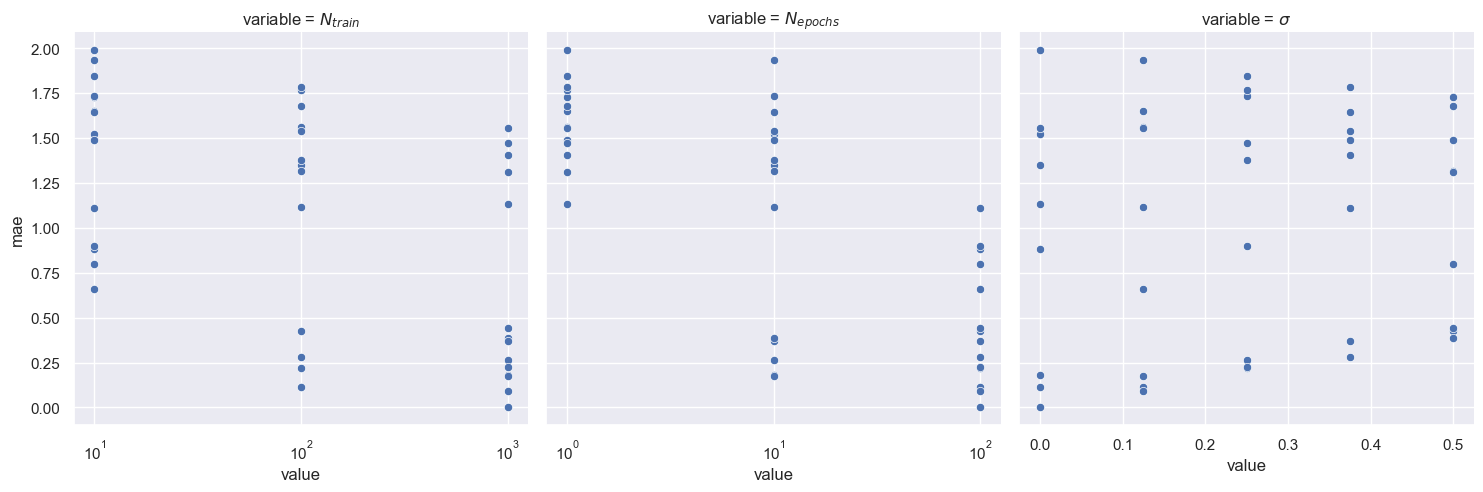

In [3]:
tag_ntrain = r"$N_{train}$"
tag_nepochs = r"$N_{epochs}$"
tag_sigma = r"$\sigma$"

# Storing the results in a pandas DataFrame, as it is very easy to plot using seaborn
results_df = pd.DataFrame.from_records(
    results, columns=[tag_ntrain, tag_nepochs, tag_sigma, "loss", METRIC]
).melt(id_vars=["loss", METRIC], value_vars=[tag_ntrain, tag_nepochs, tag_sigma])
fg = sns.relplot(
    data=results_df,
    x="value",
    y=METRIC,
    col="variable",
    kind="scatter",
    facet_kws={"sharex": False},
)
fg.axes[0, 0].set_xscale("log")
fg.axes[0, 1].set_xscale("log")


As could be expected using high values of $N_{\mathrm{train}}$, high $N_{\mathrm{epochs}}$ and low values of $\sigma$ lead to better results.

For further insights type
```bash
tensorboard --logdir={LOGDIR}
```
in the terminal to launch Tensorboard, replacing {LOGDIR} with the path you chose to store logs. The dashboard which displays results should now be accessible reaching [localhost:6006](https://localhost:6006) in a web browser. Under the tab "HPARAMS>PARALLEL COORDINATES VIEW" another kind of plot shows the results of the grid search.
